In [1]:
import re, os
import pandas as pd
import numpy as np
from pathlib import Path

# Preparation

## Variables

In [2]:
results_dir = Path("/Users/janzules/Roselab/Metabolite/results/difference/limma/intraArm/")
ORA_dir = Path("/Users/janzules/Roselab/Metabolite/results/ORA_python")

files = [f for f in results_dir.iterdir() if f.is_file()]

# B0 = files[3]
# D1 = files[2]
# D5 = files[1]
# F3 = files[4]
# F6 = files[0]

# B0 - baseline
# D1 - new start
# D5 - week 5
# F3 - month 3
# F6 - month 6
# F9 - month 9
# F12 - moth 12


In [3]:
files

[PosixPath('/Users/janzules/Roselab/Metabolite/results/difference/limma/intraArm/limma_intraArm_F6_IF_vs_NIF.csv'),
 PosixPath('/Users/janzules/Roselab/Metabolite/results/difference/limma/intraArm/limma_intraArm_D5_IF_vs_NIF.csv'),
 PosixPath('/Users/janzules/Roselab/Metabolite/results/difference/limma/intraArm/limma_intraArm_D1_IF_vs_NIF.csv'),
 PosixPath('/Users/janzules/Roselab/Metabolite/results/difference/limma/intraArm/limma_intraArm_B0_IF_vs_NIF.csv'),
 PosixPath('/Users/janzules/Roselab/Metabolite/results/difference/limma/intraArm/limma_intraArm_F3_IF_vs_NIF.csv')]

In [4]:
# B0 D1 D5 F3 F6
tp = "D1"

if tp == "B0":
    met_df = pd.read_csv(results_dir / 'limma_intraArm_B0_IF_vs_NIF.csv')
    day = "Baseline"
elif tp == "D1":
    met_df = pd.read_csv(results_dir / 'limma_intraArm_D1_IF_vs_NIF.csv')
    day = "Day 1"
elif tp == "D5":
    met_df = pd.read_csv(results_dir / 'limma_intraArm_D5_IF_vs_NIF.csv')
    day = "Week 5"
elif tp == "F3":
    met_df = pd.read_csv(results_dir / 'limma_intraArm_F3_IF_vs_NIF.csv')
    day = "Month 3"
elif tp == "F6":
    met_df = pd.read_csv(results_dir / 'limma_intraArm_F6_IF_vs_NIF.csv')
    day = "Month 6"

In [5]:
FEATURE_COL = "Index"        # unique metabolite identifier (or name)
KEGG_COL    = "kegg_maps"    # strings like "ko04211,ko04218"
PVAL_COL   = "P.Value"       # <- use your limma p-value column
LOGFC_COL   = "logFC"        # optional
ALPHA       = 0.05           # significance threshold

# Parsing

In [6]:
# Parse Kegg id's
pattern = re.compile(r'(?:ko|map|hsa)?(\d{5})$')

# Split on comma/semicolon/pipe/space, strip, keep unique 5-digit codes, sorted for stability
parsed_series = (
    met_df["kegg_map"]
    .astype(str)
    .map(lambda x: re.split(r',', x) if x.strip() != "-" else [])
    .map(lambda toks: sorted({m.group(1) for t in toks if (m := pattern.match(t.strip()))}))
)

df = met_df.copy()
df["kegg_ids"] = parsed_series

In [7]:
# tmp

In [8]:
df["p_nom"] = df[PVAL_COL].astype(float)
universe = df[df["kegg_ids"].map(len) > 0].copy()
sig_any  = universe.loc[universe["p_nom"] <= ALPHA].copy()

# optional directional splits
if "logFC" in df.columns:
    sig_up = sig_any.loc[sig_any["logFC"] > 0].copy()
    sig_dn = sig_any.loc[sig_any["logFC"] < 0].copy()
else:
    sig_up = sig_any.iloc[0:0]
    sig_dn = sig_any.iloc[0:0]

In [9]:
print(sig_up.shape)
print(sig_dn.shape)

(48, 37)
(57, 37)


In [10]:
sig_dn.shape

(57, 37)

In [11]:
# Build gene sets (GMT) from your data (universe-aware)
uni_long = universe[[FEATURE_COL, "kegg_ids"]].explode("kegg_ids").rename(columns={"kegg_ids":"pathway_id"})
members_by_pw = uni_long.groupby("pathway_id")[FEATURE_COL].apply(lambda s: sorted(set(s))).to_dict()

In [12]:
# Fetch KEGG pathway names (existing API via bioservices)
try:
    from bioservices import KEGG
    kegg = KEGG()
    path_names = {}
    for pid in members_by_pw.keys():
        # Use general maps to avoid organism-specific suffixes
        txt = kegg.get(f"path:map{pid}")  # e.g., map04211
        # crude parse for NAME line
        name = None
        for line in txt.splitlines():
            if line.strip().startswith("NAME"):
                name = line.split("NAME",1)[1].strip()
                break
        path_names[pid] = name or pid
except Exception as e:
    # Fallback: use the ID itself
    path_names = {pid: pid for pid in members_by_pw.keys()}

In [13]:
# path_names

In [14]:
# Write a temporary GMT for GSEApy (set_name, description, members...)
gmt_path = ORA_dir / "kegg_from_dataset.gmt"
with open(gmt_path, "w") as fh:
    for pid, members in members_by_pw.items():
        if not members: 
            continue
        set_name = f"KEGG_{pid}_{re.sub(r'\\W+','_', path_names.get(pid, pid))}"
        desc = f"path:{pid}"
        fh.write("\t".join([set_name, desc, *members]) + "\n")


In [15]:
gene_list_any = sorted(sig_any[FEATURE_COL].unique().tolist())
background    = sorted(universe[FEATURE_COL].unique().tolist())

In [16]:
import re, os
from pathlib import Path

# members_by_pw: {'04211': ['MEDN1278','MW0015050', ...], ...}
# gmt_path = Path("kegg_from_dataset.gmt")

def safe_name(s):
    # no spaces or punctuation in set names
    return re.sub(r"\W+", "_", s)

with gmt_path.open("w") as fh:
    for pid, members in members_by_pw.items():
        if not members:        # skip empty sets
            continue
        set_name = safe_name(f"KEGG_{pid}")
        desc = f"path:{pid}"
        fh.write("\t".join([set_name, desc, *members]) + "\n")


In [17]:
# must exist and be non-empty
assert gmt_path.exists() and gmt_path.stat().st_size > 0

# print first 2 lines
with gmt_path.open() as fh:
    for i, line in enumerate(fh):
        print(repr(line.rstrip("\n")))
        if i == 1: break


'KEGG_00010\tpath:00010\tMEDN0204\tMEDP1136\tMW0109017\tMW0109254\tMW0112272\tMW0112916\tMW0114203\tMW0115536\tMW0144947\tMW0156503'
'KEGG_00020\tpath:00020\tMEDN0202\tMEDN0204\tMW0106168\tMW0108118\tMW0109017\tMW0109022\tMW0109254\tMW0119497\tMW0169311\tMW0169880'


In [18]:
import gseapy as gp
from pathlib import Path

gene_list_any = sorted(sig_any[FEATURE_COL].unique())
background    = sorted(universe[FEATURE_COL].unique())

outdir = ORA_dir / f"gseapy_kegg_ora_any"
os.makedirs(outdir, exist_ok=True)

enr_any = gp.enrichr(
    gene_list=gene_list_any,
    gene_sets=str(gmt_path),   # <— ensure string, not Path
    format="gmt",              # <— force GMT parsing
    background=background,
    outdir=str(outdir),
    cutoff=1.0,
    no_plot=True,
)

In [19]:
res_any = enr_any.results.copy()

In [20]:
res_any

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
0,kegg_from_dataset.gmt,KEGG_00051,1/18,0.645904,0.861500,1.444019,0.631187,MW0114746
1,kegg_from_dataset.gmt,KEGG_00053,2/13,0.161288,0.829824,3.710355,6.769772,MW0123516;MW0142301
2,kegg_from_dataset.gmt,KEGG_00100,1/13,0.527052,0.849577,2.027368,1.298439,MEDP1194
3,kegg_from_dataset.gmt,KEGG_00140,2/41,0.678032,0.861500,1.063108,0.413081,MW0013889;MW0013551
4,kegg_from_dataset.gmt,KEGG_00220,1/11,0.469124,0.849577,2.416268,1.828844,FDATN01488
...,...,...,...,...,...,...,...,...
103,kegg_from_dataset.gmt,KEGG_05225,1/7,0.331367,0.829824,3.912035,4.320952,MW0168699
104,kegg_from_dataset.gmt,KEGG_05230,2/28,0.469327,0.849577,1.596482,1.207667,FDATN01488;MW0108213
105,kegg_from_dataset.gmt,KEGG_05231,10/275,0.957992,0.989317,0.626350,0.026880,MW0057079;MEDP1319;MW0056974;MW0057471;MW00570...
106,kegg_from_dataset.gmt,KEGG_05320,1/2,0.108499,0.829824,17.000000,37.757288,MEDL00630


# Filtering classes

In [21]:
# You already have: res_any with Term like "KEGG_00030_Pentose phosphate pathway"
import re
from bioservices import KEGG

# Extract 5-digit ID
res_any["pathway_id"] = res_any["Term"].str.extract(r"KEGG_(\d{5})")

# Fetch class + name once per pathway
kegg = KEGG()
klass, pname = {}, {}
for pid in res_any["pathway_id"].dropna().unique():
    txt = kegg.get(f"path:map{pid}")
    parsed = kegg.parse(txt) if txt else {}
    # NAME
    nm = parsed.get("NAME")
    if isinstance(nm, list): nm = nm[0]
    pname[pid] = (nm or "").rstrip(";").strip() or pid
    # CLASS (e.g., "Metabolism; Carbohydrate metabolism")
    cl = parsed.get("CLASS")
    if isinstance(cl, list): cl = cl[0]
    klass[pid] = (cl or "").strip()

# Add columns
res_any["kegg_class"] = res_any["pathway_id"].map(klass).fillna("")
res_any["pathway_name"] = res_any["pathway_id"].map(pname).fillna(res_any["pathway_id"])


In [22]:
# Option A: keep only Metabolism
# res_met = res_any[res_any["kegg_class"].str.startswith("Metabolism")].copy()

# Option B: exclude Human Diseases
res_met = res_any[~res_any["kegg_class"].str.startswith("Human Diseases")].copy()


In [23]:
res_met

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,pathway_id,kegg_class,pathway_name
0,kegg_from_dataset.gmt,KEGG_00051,1/18,0.645904,0.861500,1.444019,0.631187,MW0114746,00051,Metabolism; Carbohydrate metabolism,Fructose and mannose metabolism
1,kegg_from_dataset.gmt,KEGG_00053,2/13,0.161288,0.829824,3.710355,6.769772,MW0123516;MW0142301,00053,Metabolism; Carbohydrate metabolism,Ascorbate and aldarate metabolism
2,kegg_from_dataset.gmt,KEGG_00100,1/13,0.527052,0.849577,2.027368,1.298439,MEDP1194,00100,Metabolism; Lipid metabolism,Steroid biosynthesis
3,kegg_from_dataset.gmt,KEGG_00140,2/41,0.678032,0.861500,1.063108,0.413081,MW0013889;MW0013551,00140,Metabolism; Lipid metabolism,Steroid hormone biosynthesis
4,kegg_from_dataset.gmt,KEGG_00220,1/11,0.469124,0.849577,2.416268,1.828844,FDATN01488,00220,Metabolism; Amino acid metabolism,Arginine biosynthesis
...,...,...,...,...,...,...,...,...,...,...,...
86,kegg_from_dataset.gmt,KEGG_04976,1/49,0.942191,0.989317,0.511863,0.030480,MEDL00630,04976,Organismal Systems; Digestive system,Bile secretion
87,kegg_from_dataset.gmt,KEGG_04977,10/208,0.743198,0.912107,0.874873,0.259655,MW0079206;MW0167152;MW0162785;MW0069927;MW0102...,04977,Organismal Systems; Digestive system,Vitamin digestion and absorption
88,kegg_from_dataset.gmt,KEGG_04978,2/15,0.202351,0.829824,3.157094,5.044252,MEDP1194;MW0108213,04978,Organismal Systems; Digestive system,Mineral absorption
89,kegg_from_dataset.gmt,KEGG_04979,10/175,0.519528,0.849577,1.071242,0.701487,MW0079206;MW0167152;MW0162785;MW0069927;MW0102...,04979,Organismal Systems; Digestive system,Cholesterol metabolism


# Visualizing

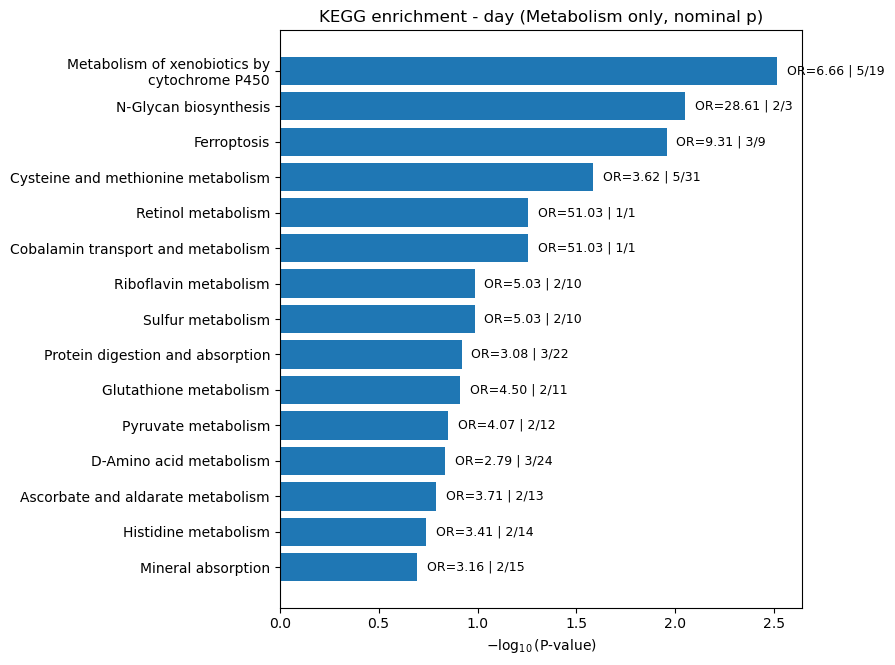

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap

res_met = res_met.sort_values(["P-value", "Term"]).copy()
res_met["neglog10p"] = -np.log10(res_met["P-value"].astype(float))
res_met["label"] = res_met["pathway_name"].map(lambda s: "\n".join(wrap(str(s), width=35)))

TOP_N = 15
top = res_met.nsmallest(TOP_N, "P-value")

plt.figure(figsize=(9, max(4, 0.45*len(top))))
y = np.arange(len(top))[::-1]
plt.barh(y, top["neglog10p"].values)
plt.yticks(y, top["label"].values)
plt.xlabel(r"$-\log_{10}(\mathrm{P\text{-}value})$")
plt.title("KEGG enrichment - day (Metabolism only, nominal p)")
for i,(xv, orr, ov) in enumerate(zip(top["neglog10p"], top["Odds Ratio"], top["Overlap"])):
    plt.text(xv+0.05, y[i], f"OR={orr:.2f} | {ov}", va="center", fontsize=9)
plt.tight_layout()
plt.show()


In [25]:
sig_any.shape

(105, 37)

In [26]:
universe.shape

(1882, 37)

# Up and Down

In [27]:
import gseapy as gp
import re, numpy as np, pandas as pd, os

gene_list_up = sorted(sig_up[FEATURE_COL].unique())
gene_list_dn = sorted(sig_dn[FEATURE_COL].unique())
background   = sorted(universe[FEATURE_COL].unique())

out_up = ORA_dir / "gseapy_kegg_ora_up";  os.makedirs(out_up, exist_ok=True)
out_dn = ORA_dir / "gseapy_kegg_ora_dn";  os.makedirs(out_dn, exist_ok=True)

enr_up = gp.enrichr(gene_list=gene_list_up, gene_sets=str(gmt_path), format="gmt",
                    background=background, outdir=str(out_up), cutoff=1.0, no_plot=True)
enr_dn = gp.enrichr(gene_list=gene_list_dn, gene_sets=str(gmt_path), format="gmt",
                    background=background, outdir=str(out_dn), cutoff=1.0, no_plot=True)

res_up = enr_up.results.copy()
res_dn = enr_dn.results.copy()

# robust Term -> (pathway_id, pathway_name) mapping that does NOT rely on GMT embedding
def extract_kegg_id(term):
    m = re.search(r'(?:KEGG_)?(\d{5})', str(term))
    return m.group(1) if m else None

for _df in (res_up, res_dn):
    _df['pathway_id'] = _df['Term'].map(extract_kegg_id)
    _df['pathway_name'] = _df['pathway_id'].map(lambda pid: path_names.get(pid, pid) if pid else None)
    # fallback if we couldn't resolve a name (e.g., API failed earlier)
    _df['pathway_name'] = _df['pathway_name'].fillna(_df['Term'])
    _df['neglog10p'] = -np.log10(_df['P-value'].astype(float))


In [28]:
res_up

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,pathway_id,pathway_name,neglog10p
0,kegg_from_dataset.gmt,KEGG_00051,1/18,0.373235,0.821605,3.279699,3.232300,MW0114746,00051,Fructose and mannose metabolism,0.428018
1,kegg_from_dataset.gmt,KEGG_00053,2/13,0.041546,0.644765,8.525012,27.117604,MW0123516;MW0142301,00053,Ascorbate and aldarate metabolism,1.381467
2,kegg_from_dataset.gmt,KEGG_00140,1/41,0.657278,0.824819,1.399220,0.587181,MW0013551,00140,Steroid hormone biosynthesis,0.182251
3,kegg_from_dataset.gmt,KEGG_00232,2/19,0.082717,0.756269,5.583717,13.916472,MW0014197;MW0108505,00232,Caffeine metabolism,1.082406
4,kegg_from_dataset.gmt,KEGG_00260,1/22,0.435391,0.821605,2.663647,2.214851,MEDP0322,00260,"Glycine, serine and threonine metabolism",0.361120
...,...,...,...,...,...,...,...,...,...,...,...
59,kegg_from_dataset.gmt,KEGG_05225,1/7,0.165683,0.821605,8.883401,15.969478,MW0168699,05225,Hepatocellular carcinoma,0.780721
60,kegg_from_dataset.gmt,KEGG_05230,1/28,0.517468,0.821605,2.075598,1.367420,MW0108213,05230,Central carbon metabolism in cancer,0.286117
61,kegg_from_dataset.gmt,KEGG_05231,6/275,0.724589,0.827541,0.888421,0.286205,MEDP1319;MW0056974;MW0057470;MEDP1333;MW005744...,05231,Choline metabolism in cancer,0.139908
62,kegg_from_dataset.gmt,KEGG_05320,1/2,0.050372,0.644765,38.600000,115.348927,MEDL00630,05320,Autoimmune thyroid disease,1.297808


In [29]:
# If you already computed res_any["kegg_class"], reuse that mapping:
# klass: dict {pid -> "Metabolism; ..."}
res_up["kegg_class"] = res_up["pathway_id"].map(klass).fillna("")
res_dn["kegg_class"] = res_dn["pathway_id"].map(klass).fillna("")
# res_up = res_up[res_up["kegg_class"].str.startswith("Metabolism")].copy()
# res_dn = res_dn[res_dn["kegg_class"].str.startswith("Metabolism")].copy()


In [31]:
def add_overlap_counts(df):
    kk = df["Overlap"].str.split("/", expand=True).astype(int)
    df["k_in_set"] = kk[0]      # sig hits in this pathway
    df["K_size"]   = kk[1]      # pathway size in background
    df["k_over_n"] = df["k_in_set"] / len(gene_list_up if df is res_up else gene_list_dn)  # optional
    return df

res_up = add_overlap_counts(res_up)
res_dn = add_overlap_counts(res_dn)

res_up = res_up[res_up["k_in_set"] >= 2].copy()
res_dn = res_dn[res_dn["k_in_set"] >= 2].copy()


In [32]:
import matplotlib.pyplot as plt
from textwrap import wrap

def plot_top(df, title, out_png, topn=15, alpha=0.05):
    if df.empty:
        print(f"No enriched pathways to plot for: {title}")
        return
    
    df = df.sort_values(["P-value","Term"]).head(topn).copy()
    df["label"] = df["pathway_name"].map(lambda s: "\n".join(wrap(str(s), width=35)))

    plt.figure(figsize=(9, max(4, 0.45*len(df))))
    y = np.arange(len(df))[::-1]
    plt.barh(y, df["neglog10p"].values, color="steelblue")
    plt.yticks(y, df["label"].values)
    plt.xlabel(r"$-\log_{10}(\mathrm{P\text{-}value})$")
    plt.title(title)

    # Add vertical significance line
    sig_thresh = -np.log10(alpha)
    plt.axvline(sig_thresh, color="red", linestyle="--", linewidth=1)
    plt.text(sig_thresh+0.05, -0.5, f"p={alpha}", color="red", fontsize=9)

    for i,(xv, orr, ov) in enumerate(zip(df["neglog10p"], df["Odds Ratio"], df["Overlap"])):
        plt.text(xv+0.05, y[i], f"OR={orr:.2f} | {ov}", va="center", fontsize=9)

    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", out_png)

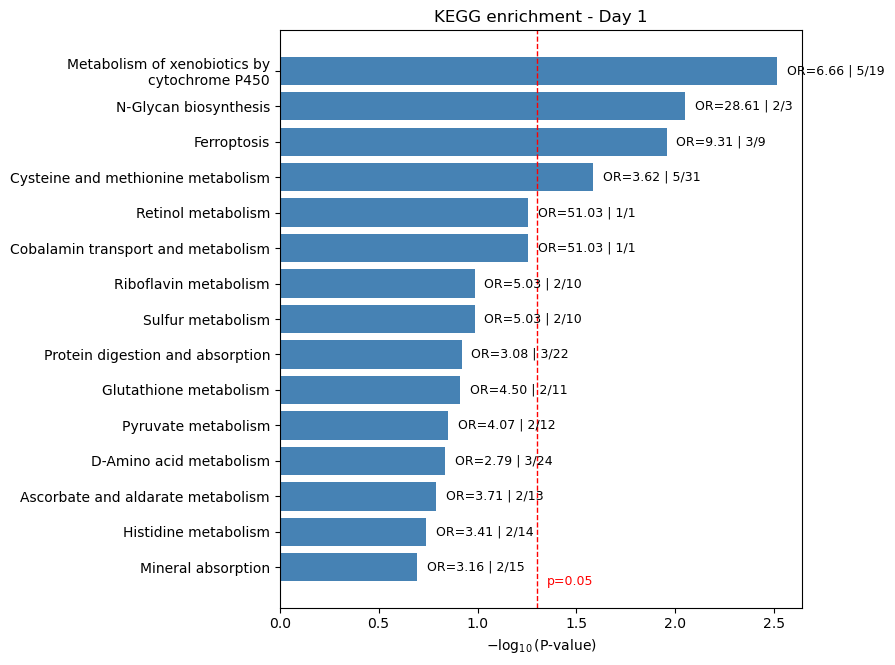

Saved: /Users/janzules/Roselab/Metabolite/results/ORA_python/plots/met_kegg_enrichment_any_Pval_Day 1.png


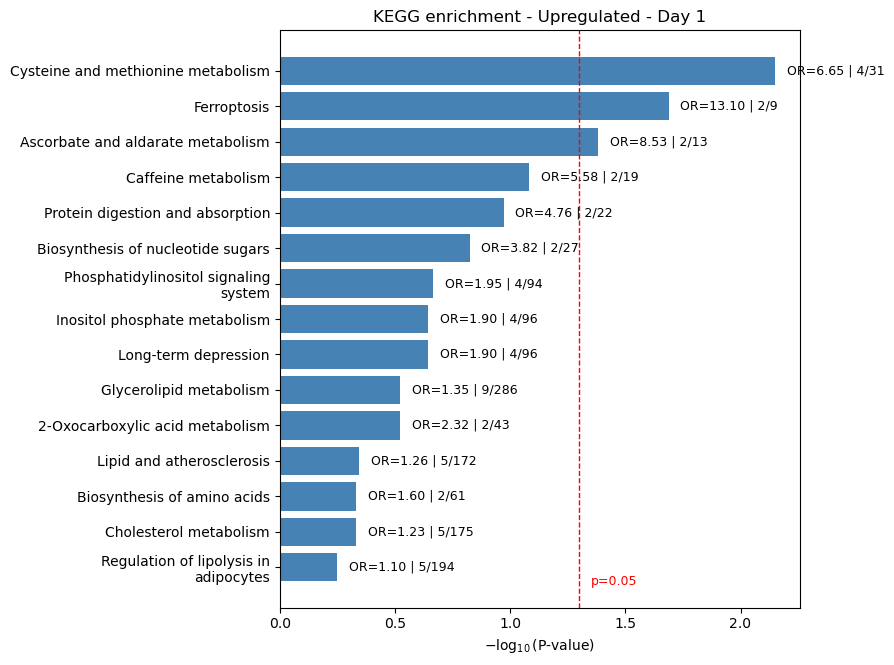

Saved: /Users/janzules/Roselab/Metabolite/results/ORA_python/plots/met_kegg_enrichment_up_Pval_Day 1.png


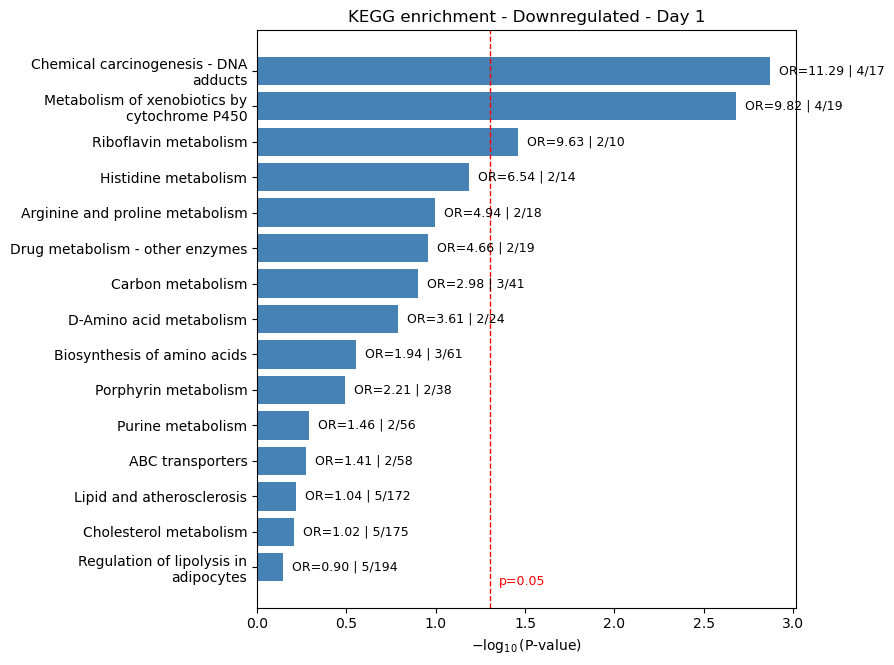

Saved: /Users/janzules/Roselab/Metabolite/results/ORA_python/plots/met_kegg_enrichment_dn_Pval_Day 1.png


In [45]:
plot_top(res_met, f"KEGG enrichment - {day}",
        ORA_dir / f"plots/met_kegg_enrichment_any_Pval_{day}.png")

plot_top(res_up, f"KEGG enrichment - Upregulated - {day}",
         ORA_dir / f"plots/met_kegg_enrichment_up_Pval_{day}.png")

plot_top(res_dn, f"KEGG enrichment - Downregulated - {day}",
         ORA_dir / f"plots/met_kegg_enrichment_dn_Pval_{day}.png")

# Identifying metabolites

In [41]:
res.columns

Index(['Gene_set', 'Term', 'Overlap', 'P-value', 'Adjusted P-value',
       'Odds Ratio', 'Combined Score', 'Genes', 'pathway_id', 'kegg_class',
       'pathway_name'],
      dtype='object')

In [40]:
if "pathway_id" not in res.columns or "pathway_name" not in res.columns:
    print("True")

In [46]:
import re, difflib
import pandas as pd

def find_pathway_row(res: pd.DataFrame, query: str):
    # Ensure we have pathway_id + pathway_name columns
    if "pathway_id" not in res.columns or "pathway_name" not in res.columns:
        m = res["Term"].str.extract(r"KEGG_(\d{5})_(.*)$")
        res = res.copy()
        res["pathway_id"]   = m[0].fillna(res["Term"].str.extract(r"KEGG_(\d{5})")[0])
        res["pathway_name"] = m[1].fillna(res["Term"])
        res["pathway_name"] = res["pathway_name"].astype(str).str.strip()

    q = query.strip()
    pat = re.escape(q)                      # escape regex specials

    mask = (
        res["pathway_name"].astype(str).str.contains(pat, case=False, regex=True) |
        res["Term"].astype(str).str.contains(pat, case=False, regex=True) |
        (res.get("pathway_id","").astype(str) == q)
    )

    if mask.any():
        # return the best match (smallest p-value)
        return res.loc[mask].sort_values("P-value").iloc[0], res

    # Fuzzy suggestions if nothing matched
    candidates = res["pathway_name"].astype(str).tolist()
    sugg = difflib.get_close_matches(q, candidates, n=5, cutoff=0.6)
    raise ValueError(f"No pathway matched: {q}. Close matches: {sugg}")

# --- use on your DOWN table (or res_up/res_any) ---
row, res_used = find_pathway_row(res_met, "Ferr")

# Extract the significant metabolites (the ones “triggering” it)
hits = [x.strip() for x in str(row["Genes"]).replace(",", ";").split(";") if x.strip()]
k, K = map(int, str(row["Overlap"]).split("/"))

print(f"{row.get('pathway_name')} (KEGG {row.get('pathway_id')})")
print(f"Overlap k/K = {k}/{K} | P={row['P-value']:.3g} | OR={row['Odds Ratio']:.2f}")
print("Hits:", hits)

# Join back to your original dataframe to see stats for those metabolites
cols = [FEATURE_COL] + [c for c in ["metabolite","name","P.Value","p_nom","logFC","kegg_maps"] if c in df.columns]
hits_df = (df[df[FEATURE_COL].isin(hits)][cols]
           .sort_values(by=[c for c in ["p_nom","P.Value","logFC"] if c in df.columns]))
display(hits_df)


Ferroptosis (KEGG 04216)
Overlap k/K = 3/9 | P=0.0111 | OR=9.31
Hits: ['MW0107690', 'MW0048971', 'FDATN01488']


,Index,P.Value,p_nom,logFC
2295,MW0048971,0.017299,0.017299,0.766845
106,FDATN01488,0.023721,0.023721,-0.638306
4172,MW0107690,0.026767,0.026767,0.411560
